In [1]:
%run ../nn_option_pricer/_key_imports.py
import sys
sys.path.append("../")
from nn_option_pricer.bs import bs_eval_wrapper, bs_model_inference
from nn_option_pricer.nn_archi import *
from nn_option_pricer.utils import diagnosis_hedge, visualise_surface
%run ../nn_option_pricer/default_config.py

In [2]:
# read in dataset
target = "ttm"
feat_names = ["K", "T", "call_true"]
f_to_i = lambda x: feat_names.index(x)
N_FEATS = len(feat_names)
# train set
from numpy.random import default_rng
X_df = pd.read_csv("datasets/bs_train.csv")
X_df['K'] = np.exp(- X_df['log(S/K)'])
rng = default_rng(42)
X_df['T'] = rng.uniform(1,  3, X_df.shape[0])

Xs_train, ys_train = X_df[feat_names].values, X_df[target].values
ys_train = ys_train / np.sqrt(X_df['T']).values
# test set
X_df_test = pd.read_csv("datasets/bs_test.csv")
X_df_test['K'] = np.exp(- X_df_test['log(S/K)'])
rng = default_rng(2022)
X_df_test['T'] = rng.uniform(1, 3, X_df.shape[0])
Xs_test, ys_test = X_df_test[feat_names].values, X_df_test[target].values
ys_test = ys_test / np.sqrt(X_df_test['T'])

all_res = []
all_model_preds = {}
all_model_grads = {}
all_model_hessian = {}
all_models = {}

In [4]:
METHOD = "resnet"
fit_params['batch_size'] = 256
fit_params['epochs'] = 30
LR = 1e-1
nn_params["n_feats"] = N_FEATS
nn_params["hidden_units"] = 100

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 3)           12          ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dense_3 (Dense)                (None, 100)          400         ['batch_normalization_3[0][0]']  
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 100)         400         ['dense_3[0][0]']          

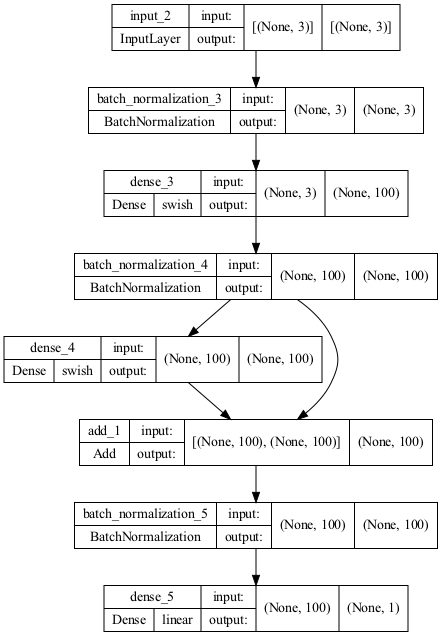

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3)]               0         
                                                                 
 batch_normalization_6 (Batc  (None, 3)                12        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 100)               400       
                                                                 
 batch_normalization_7 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_8 (Batc  (None, 100)              400 

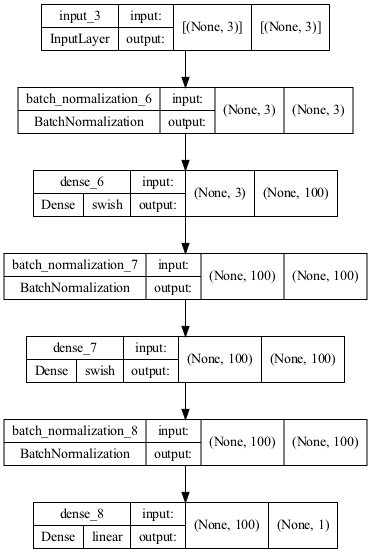

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

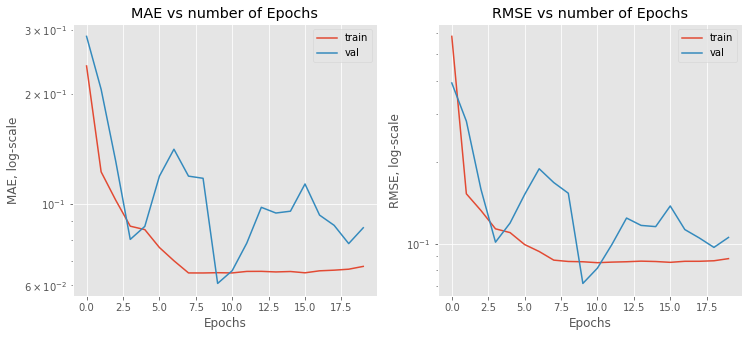

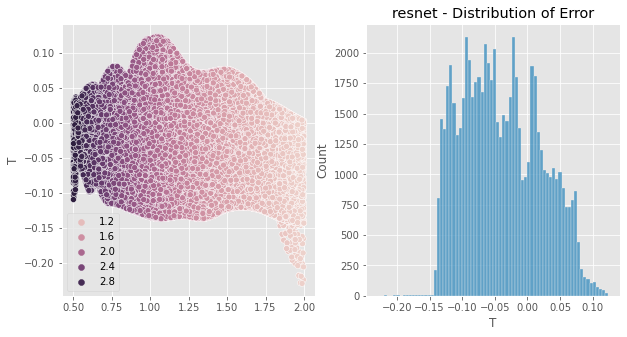

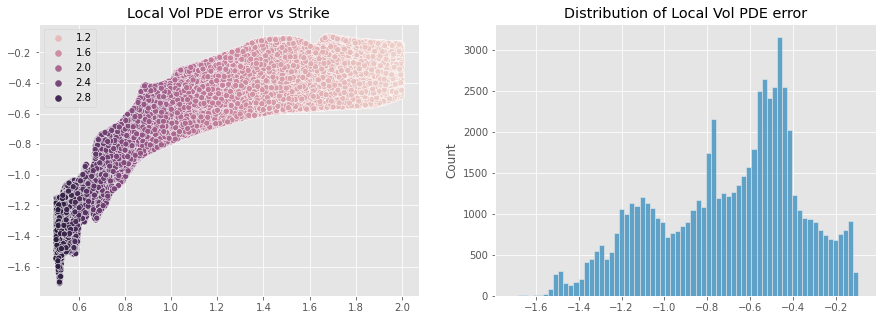

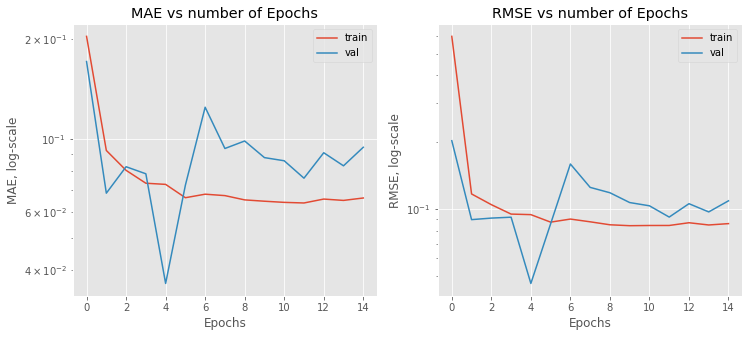

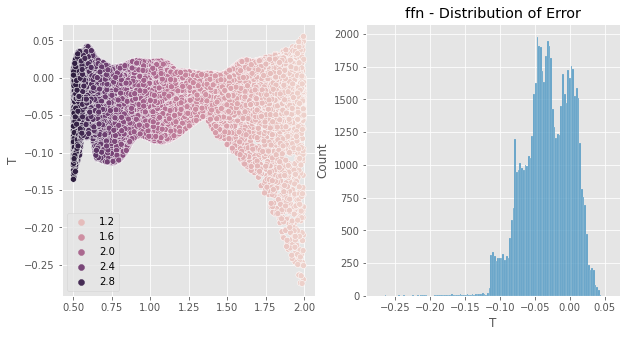

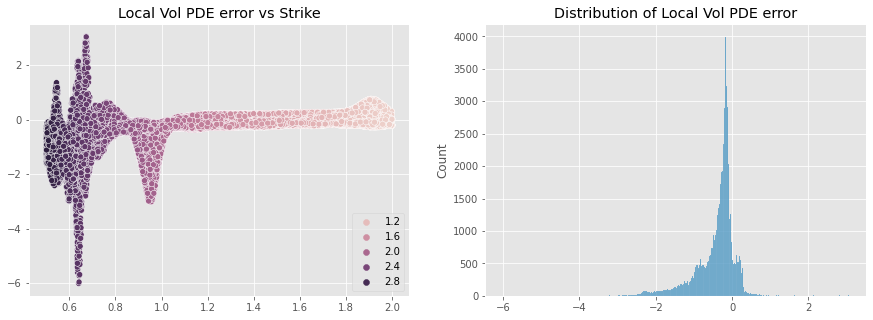

In [9]:
import time
for METHOD in ["resnet", "ffn"]:
    if METHOD == "resnet":
        nn_params2 = nn_params.copy()
        nn_params2['resnet'] = True
        all_models[METHOD] = make_model(**nn_params2)
    else:
        all_models[METHOD] = make_model(**nn_params)
    
    opt = Adam(learning_rate=ExponentialDecay(LR, decay_steps=500,
        decay_rate=0.95,
    ))


    ### re-instantiate the optimizer, and compile the neural network
    all_models[METHOD].compile(optimizer=opt, **compile_params)
    ### summarize model
    all_models[METHOD].summary()
    display(tf.keras.utils.plot_model(
        all_models[METHOD], show_layer_activations=True, show_shapes=True, dpi=72
    ))
    
    train_time, history = train_nn(all_models[METHOD], Xs_train, ys_train, fit_params, metric_names)
    
    start2 = time.time() 
    all_model_preds[METHOD] = all_models[METHOD].predict(Xs_test).reshape(-1)
    X_tensor = tf.Variable(Xs_test)
    with tf.GradientTape() as tape2:
        with tf.GradientTape() as tape:
            output = all_models[METHOD](X_tensor)
            grads = tape.gradient(output, X_tensor)
        hessian = tape2.gradient(grads[:, f_to_i("K")], X_tensor)
    all_model_grads[METHOD] = grads.numpy()
    all_model_hessian[METHOD] = hessian.numpy()
    inference_time = time.time() - start2
    
    fig, ax = plt.subplots(ncols =2, figsize=(10, 5))
    sns.scatterplot(Xs_test[:, f_to_i("K")], ys_test - all_model_preds[METHOD], ax = ax[0], hue = Xs_test[:, f_to_i("T")])
    ax[0].set_title(f"{METHOD} - Error vs Moneyness")
    sns.histplot(ys_test - all_model_preds[METHOD], ax = ax[1])
    ax[1].set_title(f"{METHOD} - Distribution of Error")
    
    dCdT = (1 / all_model_grads[METHOD][:, f_to_i("call_true")]) * all_model_grads[METHOD][:, f_to_i("T")]
    
    d2CdK2 = (((1 / all_model_grads[METHOD][:, f_to_i("call_true")]) * 
               all_model_hessian[METHOD][:, f_to_i("K")]) - 
              ((1 / all_model_grads[METHOD][:, f_to_i("call_true")]) ** 2 * 
               (all_model_hessian[METHOD][:, f_to_i("call_true")]) *
               all_model_grads[METHOD][:, f_to_i("K")]))
        
        
    dupire_local_vol_pde = (dCdT - d2CdK2 * all_model_preds[METHOD] ** 2)
    # dupire_local_vol_pde2 = (all_model_grads[METHOD][:, f_to_i("T")] - 
    #                            (
    #                                all_model_hessian[METHOD][:, f_to_i("K")] - 
    #                                (all_model_preds[METHOD] ** 2) * (
    #                                     (1 / all_model_grads[METHOD][:, f_to_i("call_true")]) * 
    #                                all_model_hessian[METHOD][:, f_to_i("call_true")] *
    #                                all_model_grads[METHOD][:, f_to_i("K")]
    #                                )
    #                            )
    #                         )
    fig, ax = plt.subplots(ncols = 2, figsize=(15, 5))
    sns.scatterplot(Xs_test[:, f_to_i("K")], dupire_local_vol_pde, hue = Xs_test[:, f_to_i("T")], ax = ax[0])
    sns.histplot(dupire_local_vol_pde, ax = ax[1])
    ax[1].set_title("Distribution of Local Vol PDE error")
    ax[0].set_title("Local Vol PDE error vs Strike")

In [ ]:
# read in dataset
target = "call_true"
feat_names = ["K", "T"]
f_to_i = lambda x: feat_names.index(x)
N_FEATS = len(feat_names)
# train set
from numpy.random import default_rng
X_df = pd.read_csv("datasets/bs_train.csv")
X_df['K'] = np.exp(- X_df['log(S/K)'])
rng = default_rng(42)
X_df['T'] = rng.uniform(1,  3, X_df.shape[0])

Xs_train, ys_train = X_df[feat_names].values, X_df[target].values
# test set
X_df_test = pd.read_csv("datasets/bs_test.csv")
X_df_test['K'] = np.exp(- X_df_test['log(S/K)'])
rng = default_rng(2022)
X_df_test['T'] = rng.uniform(1, 3, X_df.shape[0])
Xs_test, ys_test = X_df_test[feat_names].values, X_df_test[target].values

all_res = []
all_model_preds = {}
all_model_grads = {}
all_model_hessian = {}
all_models = {}

$$\frac{\partial C}{\partial T} = \frac{\partial^{2}C}{\partial K^{2}} \frac{\sigma^{2}(T, K)}{2}$$

$\frac{\partial C}{\partial \sigma} \frac{\partial \sigma}{\partial T}$

$\frac{\partial C}{\partial y} \frac{\partial y}{\partial \tau} = \frac{\partial C}{\partial y} \frac{\sigma^{2}}{2 y}$

$\frac{\partial C}{\partial K} = \frac{\partial C}{\partial y} \frac{\partial y}{\partial K} = \frac{\partial C}{\partial y} \frac{\partial y}{\partial m} \frac{\partial m}{\partial K} = \frac{\partial C}{\partial y} \frac{\partial y}{\partial m} \frac{-1}{K}$

$ -(\frac{\partial y}{\partial C})^{-2} (\frac{\partial y}{\partial K})^{2} + \frac{\partial C}{\partial y} \frac{\partial^{2}y}{\partial K^{2}}$

$$\frac{\partial C}{\partial y} \frac{\partial y}{\partial m} \frac{1}{K^{2}} - \frac{1}{K}[]$$


$$\frac{\partial C}{\partial T} = (\frac{\partial y}{\partial C})^{-1} \frac{\partial y}{\partial T}$$

$$\frac{\partial C}{\partial K} = (\frac{\partial y}{\partial C})^{-1} \frac{\partial y}{\partial K}$$

$$\frac{\partial^{2} C}{\partial K^{2}} = (\frac{\partial y}{\partial C})^{-1} \frac{\partial^{2} y}{\partial K^{2}}- \frac{\partial y}{\partial K} (\frac{\partial y}{\partial C})^{-2} \frac{\partial^{2} y}{\partial C \partial K}$$

$\frac{\partial }{\partial K} (\frac{\partial y}{\partial C} = \frac{\partial }{\partial C} \frac{\partial C}{\partial y}\frac{\partial y}{\partial K} $


\begin{align}
\frac{\partial C}{\partial T} &= \frac{\partial y}{\partial T} \cdot \frac{\partial C}{\partial y} = \frac{\partial y}{\partial T} \cdot (\frac{\partial y}{\partial C})^{-1}\\
\frac{\partial C}{\partial K} &= \frac{\partial y}{\partial K} \cdot \frac{\partial C}{\partial y} = \frac{\partial y}{\partial K} \cdot (\frac{\partial y}{\partial C})^{-1}\\
\frac{\partial^{2} C}{\partial K^{2}} &= \frac{\partial}{\partial K} (\frac{\partial y}{\partial K} \cdot (\frac{\partial y}{\partial C})^{-1}) = \frac{\partial^{2}y}{\partial K^{2}} \cdot (\frac{\partial y}{\partial C})^{-1} - \frac{\partial y}{\partial K} (\frac{\partial y}{\partial C})^{-2} \frac{\partial^{2}y}{\partial C \partial K}\\
\end{align}